In [1]:
import math
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit
from qiskit_aer import AerSimulator
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary

# Set random seed
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

In [2]:
# Configure parameters
n_qubits = 5  # Total number of qubits / N
n_a_qubits = 1  # Number of ancillary qubits / N_A
q_depth = 6  # Depth of the parameterised quantum circuit / D
n_generators = 4  # Number of subgenerators for the patch method / N_G
image_size = 8  
batch_size = 1
lrG = 0.03  # Learning rate for the generator
lrD = 0.001  # Learning rate for the discriminator
num_iter = 1600  # Number of training iterations

In [3]:
# Dataset
class DigitsDataset(Dataset):
    def __init__(self, csv_file, label=0, transform=None):
        self.csv_file = csv_file
        self.transform = transform
        self.df = self.filter_by_label(label)

    def filter_by_label(self, label):
        df = pd.read_csv(self.csv_file)
        df = df.loc[df.iloc[:, -1] == label]
        return df

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        image = self.df.iloc[idx, :-1] / 16
        image = np.array(image).astype(np.float32).reshape(8, 8)
        if self.transform:
            image = self.transform(image)
        return image, 0

# DataLoader
dataset = DigitsDataset(csv_file="D:/4. MACHINE LEARNING/GAN/data_qgans/optdigits.tra")
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)



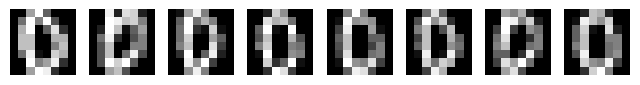

In [4]:
# Display some sample images
plt.figure(figsize=(8, 2))
for i in range(8):
    image = dataset[i][0]
    plt.subplot(1, 8, i + 1)
    plt.axis('off')
    plt.imshow(image, cmap='gray')
plt.show()

In [5]:
# Discriminator
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(image_size * image_size, 64),
            nn.ReLU(),
            nn.Linear(64, 16),
            nn.ReLU(),
            nn.Linear(16, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        return self.model(x)
discriminator = Discriminator()
# summary(discriminator, (image_size * image_size,))

In [6]:
def create_quantum_circuit(noise, weights):
    """Create quantum circuit with proper weight structure"""
    circuit = QuantumCircuit(n_qubits)
    weights = weights.reshape(q_depth, n_qubits)
    # Apply initial rotations based on noise input
    # Initialise latent vectors
    for i in range(n_qubits):
        circuit.ry(float(noise[i]), i)
    
    # Repeated layer structure
    for d in range(q_depth):
        for i in range(n_qubits):
            circuit.ry(float(weights[d][i]), i)
        for i in range(n_qubits - 1):
            circuit.cz(i, i + 1)
    
    circuit.measure_all()
    return circuit

def partial_measure(noise, weights):
    """Execute quantum circuit and return measurement probabilities"""
    circuit = create_quantum_circuit(noise, weights)
    simulator = AerSimulator()
    job = simulator.run(circuit, shots=2048)
    result = job.result()
    counts = result.get_counts()
    
    # Process measurement results
    probs = np.zeros(2 ** n_qubits)
    for state, count in counts.items():
        idx = int(state[::-1], 2)
        probs[idx] = count
    probs /= np.sum(probs)
    
    # Calculate conditional probabilities
    probsgiven0 = probs[:2 ** (n_qubits - n_a_qubits)]
    if np.sum(probsgiven0) > 0:
        probsgiven0 /= np.sum(probsgiven0)
    return probsgiven0



In [7]:
class PatchQuantumGenerator:
    def __init__(self, n_generators, q_delta=1):
        """
        Args:
            n_generators (int): Number of sub-generators to be used in the patch method.
            q_delta (float, optional): Spread of the random distribution for parameter initialization.
        """
        self.q_params = [
            torch.tensor(q_delta * np.random.rand(q_depth * n_qubits), dtype=torch.float32, requires_grad=True)
            for _ in range(n_generators)
        ]
        self.n_generators = n_generators

    def forward(self, x):
        patch_size = 2 ** (n_qubits - n_a_qubits)
        images = np.empty((x.shape[0], 0))

        for params in self.q_params:
            patches = np.empty((0, patch_size))
            for elem in x:
                q_out = partial_measure(elem, params.detach().numpy())
                patches = np.concatenate((patches, q_out.reshape(1, -1)))

            images = np.concatenate((images, patches), axis=1)

        return images


    def zero_grad(self):
        """Reset gradients of all the parameters of the generator"""
        for params in self.q_params:
            if params.grad is not None:
                params.grad.zero_()

    def parameters(self):
        """Return all the parameters (weights) of the quantum generator as PyTorch tensors."""
        return self.q_params


In [8]:
generator = PatchQuantumGenerator(n_generators=n_generators)

In [9]:
generator.q_params

[tensor([0.3745, 0.9507, 0.7320, 0.5987, 0.1560, 0.1560, 0.0581, 0.8662, 0.6011,
         0.7081, 0.0206, 0.9699, 0.8324, 0.2123, 0.1818, 0.1834, 0.3042, 0.5248,
         0.4319, 0.2912, 0.6119, 0.1395, 0.2921, 0.3664, 0.4561, 0.7852, 0.1997,
         0.5142, 0.5924, 0.0465], requires_grad=True),
 tensor([0.6075, 0.1705, 0.0651, 0.9489, 0.9656, 0.8084, 0.3046, 0.0977, 0.6842,
         0.4402, 0.1220, 0.4952, 0.0344, 0.9093, 0.2588, 0.6625, 0.3117, 0.5201,
         0.5467, 0.1849, 0.9696, 0.7751, 0.9395, 0.8948, 0.5979, 0.9219, 0.0885,
         0.1960, 0.0452, 0.3253], requires_grad=True),
 tensor([0.3887, 0.2713, 0.8287, 0.3568, 0.2809, 0.5427, 0.1409, 0.8022, 0.0746,
         0.9869, 0.7722, 0.1987, 0.0055, 0.8155, 0.7069, 0.7290, 0.7713, 0.0740,
         0.3585, 0.1159, 0.8631, 0.6233, 0.3309, 0.0636, 0.3110, 0.3252, 0.7296,
         0.6376, 0.8872, 0.4722], requires_grad=True),
 tensor([0.1196, 0.7132, 0.7608, 0.5613, 0.7710, 0.4938, 0.5227, 0.4275, 0.0254,
         0.1079, 0.0314, 

In [10]:
# Binary Cross-Entropy Loss function
criterion = nn.BCELoss()

# Optimizer cho Generator
optG = optim.SGD(generator.parameters(), lr=lrG)

# Optimizer cho Discriminator
optD = optim.SGD(discriminator.parameters(), lr=lrD)




In [11]:
real_labels = torch.full((batch_size,), 1.0, dtype=torch.float)
fake_labels = torch.full((batch_size,), 0.0, dtype=torch.float)
# print (real_labels)
# print (fake_labels)
# Fixed noise allows us to visually track the generated images throughout training
fixed_noise = torch.rand(8, n_qubits) * math.pi / 2
# print (fixed_noise)

Iteration: 100, Discriminator Loss: 1.367, Generator Loss: 0.581


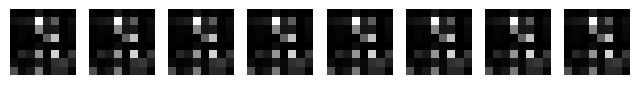

Iteration: 200, Discriminator Loss: 1.352, Generator Loss: 0.587


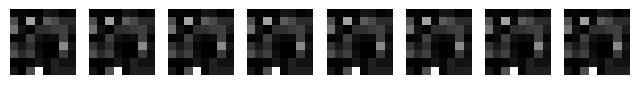

Iteration: 300, Discriminator Loss: 1.340, Generator Loss: 0.588


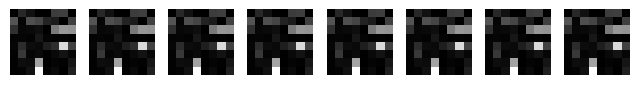

Iteration: 400, Discriminator Loss: 1.285, Generator Loss: 0.611


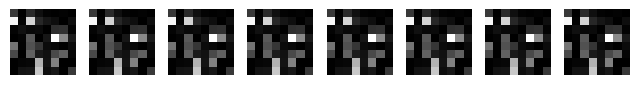

Iteration: 500, Discriminator Loss: 1.283, Generator Loss: 0.622


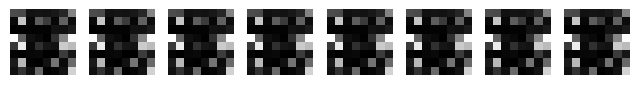

Iteration: 600, Discriminator Loss: 1.259, Generator Loss: 0.621


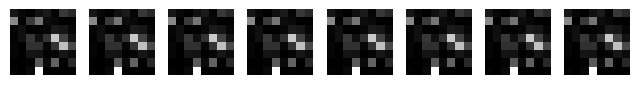

Iteration: 700, Discriminator Loss: 1.211, Generator Loss: 0.664


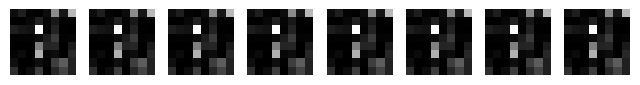

Iteration: 800, Discriminator Loss: 1.167, Generator Loss: 0.650


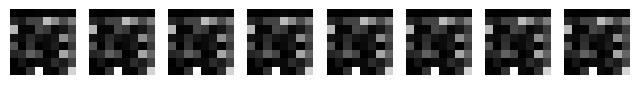

Iteration: 900, Discriminator Loss: 1.178, Generator Loss: 0.634


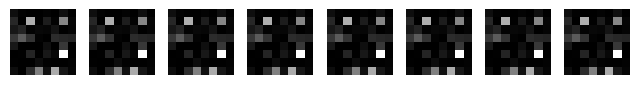

Iteration: 1000, Discriminator Loss: 1.150, Generator Loss: 0.674


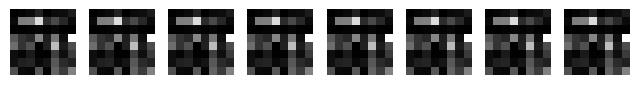

Iteration: 1100, Discriminator Loss: 1.028, Generator Loss: 0.705


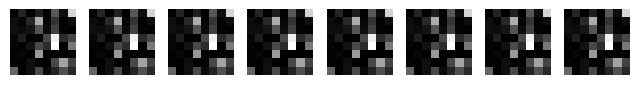

Iteration: 1200, Discriminator Loss: 1.056, Generator Loss: 0.672


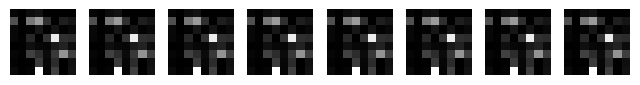

Iteration: 1300, Discriminator Loss: 0.905, Generator Loss: 0.765


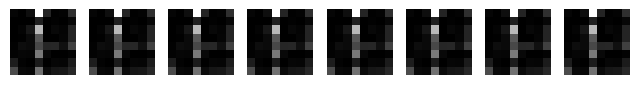

Iteration: 1400, Discriminator Loss: 0.877, Generator Loss: 0.759


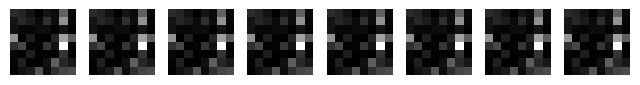

Iteration: 1500, Discriminator Loss: 0.816, Generator Loss: 0.795


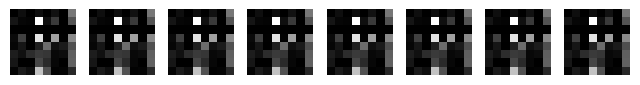

Iteration: 1600, Discriminator Loss: 0.728, Generator Loss: 0.868


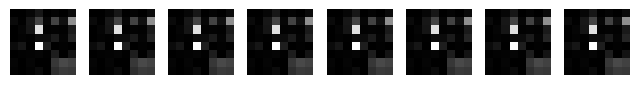

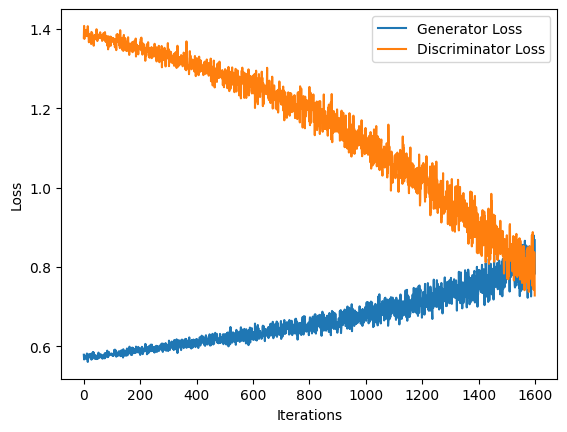

In [12]:
# Define the loss function for the generator
def generator_loss_func(fake_data):
    """Calculate the generator's loss based on the discriminator's output."""
    outD_fake = discriminator(torch.tensor(fake_data, dtype=torch.float32)).view(-1)
    return criterion(outD_fake, real_labels).item()

# Training loop
counter = 0
generator_losses = []
discriminator_losses = []

while True:
    for i, (data, _) in enumerate(dataloader):

        # Prepare data for the Discriminator
        data = data.reshape(-1, image_size * image_size)
        real_data = data

        # Generate noise for fake data
        noise = torch.rand(batch_size, n_qubits) * math.pi
        fake_data = generator.forward(noise.numpy())  # Generate fake data from the generator
        fake_data_tensor = torch.tensor(fake_data, dtype=torch.float32)

        # Train the Discriminator
        discriminator.zero_grad()
        outD_real = discriminator(real_data).view(-1)
        outD_fake = discriminator(fake_data_tensor.detach()).view(-1)

        errD_real = criterion(outD_real, real_labels)
        errD_fake = criterion(outD_fake, fake_labels)

        errD_real.backward()
        errD_fake.backward()

        errD = errD_real + errD_fake
        optD.step()  # Update the Discriminator's weights
        discriminator_losses.append(errD.item())

        # Train the Generator
        generator.zero_grad()
        outD_fake = discriminator(fake_data_tensor).view(-1)
        errG = criterion(outD_fake, real_labels)  # Generator's loss
        errG.backward()
        optG.step()  # Update the Generator's weights
        generator_losses.append(errG.item())
        counter += 1
        if counter % 100 == 0:
            print(f'Iteration: {counter}, Discriminator Loss: {errD.item():0.3f}, Generator Loss: {errG.item():0.3f}')
        # Plot the generated image samples
            plt.figure(figsize=(8, 2))
            for i in range(8):
                fake_image = fake_data[0].reshape(image_size, image_size)
                plt.subplot(1, 8, i + 1)
                plt.axis('off')
                plt.imshow(fake_image, cmap='gray')
            plt.show()

        if counter == num_iter:
            break

    if counter == num_iter:
        break

# Plot the loss graph
plt.plot(generator_losses, label="Generator Loss")
plt.plot(discriminator_losses, label="Discriminator Loss")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()
